In [356]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
import math

In [357]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sopprimi i RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [358]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [359]:
# dati = pd.read_csv('Bitcoin (€) da yfinance dal 06-05-2022 alle 21 al 05-05-2024 alle 19 con granularità oraria.csv')
# dati = dati[['Datetime', 'Close']]
# dati = dati.rename(columns = {'Datetime':'Timestamp', 'Close': 'Price'})
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d %H')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d %H')
# dati

In [360]:
# data_inizio = '2020-02-29'
# data_fine = '2020-09-01'
data_inizio = '2020-12-01'
data_fine = '2021-04-30'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2020-12-01,15576.629883
1,2020-12-02,15850.040039
2,2020-12-03,16010.777344
3,2020-12-04,15428.222656
4,2020-12-05,15799.846680
...,...,...
146,2021-04-26,44721.855469
147,2021-04-27,45522.515625
148,2021-04-28,45178.683594
149,2021-04-29,44170.968750


In [361]:
# data_inizio = '2023-06-01 00'
# data_fine = '2023-12-01 00'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

### Eventuale cambio dati

In [362]:
def calcola_prezzo(t):
    return dati['Price'][t] #1000 - t + 100 * math.sin(2*math.pi * t / 4)

In [363]:
dati['Price'] = dati.index.map(calcola_prezzo)
dati

,Timestamp,Price
0,2020-12-01,15576.629883
1,2020-12-02,15850.040039
2,2020-12-03,16010.777344
3,2020-12-04,15428.222656
4,2020-12-05,15799.846680
...,...,...
146,2021-04-26,44721.855469
147,2021-04-27,45522.515625
148,2021-04-28,45178.683594
149,2021-04-29,44170.968750


### Grafico dati

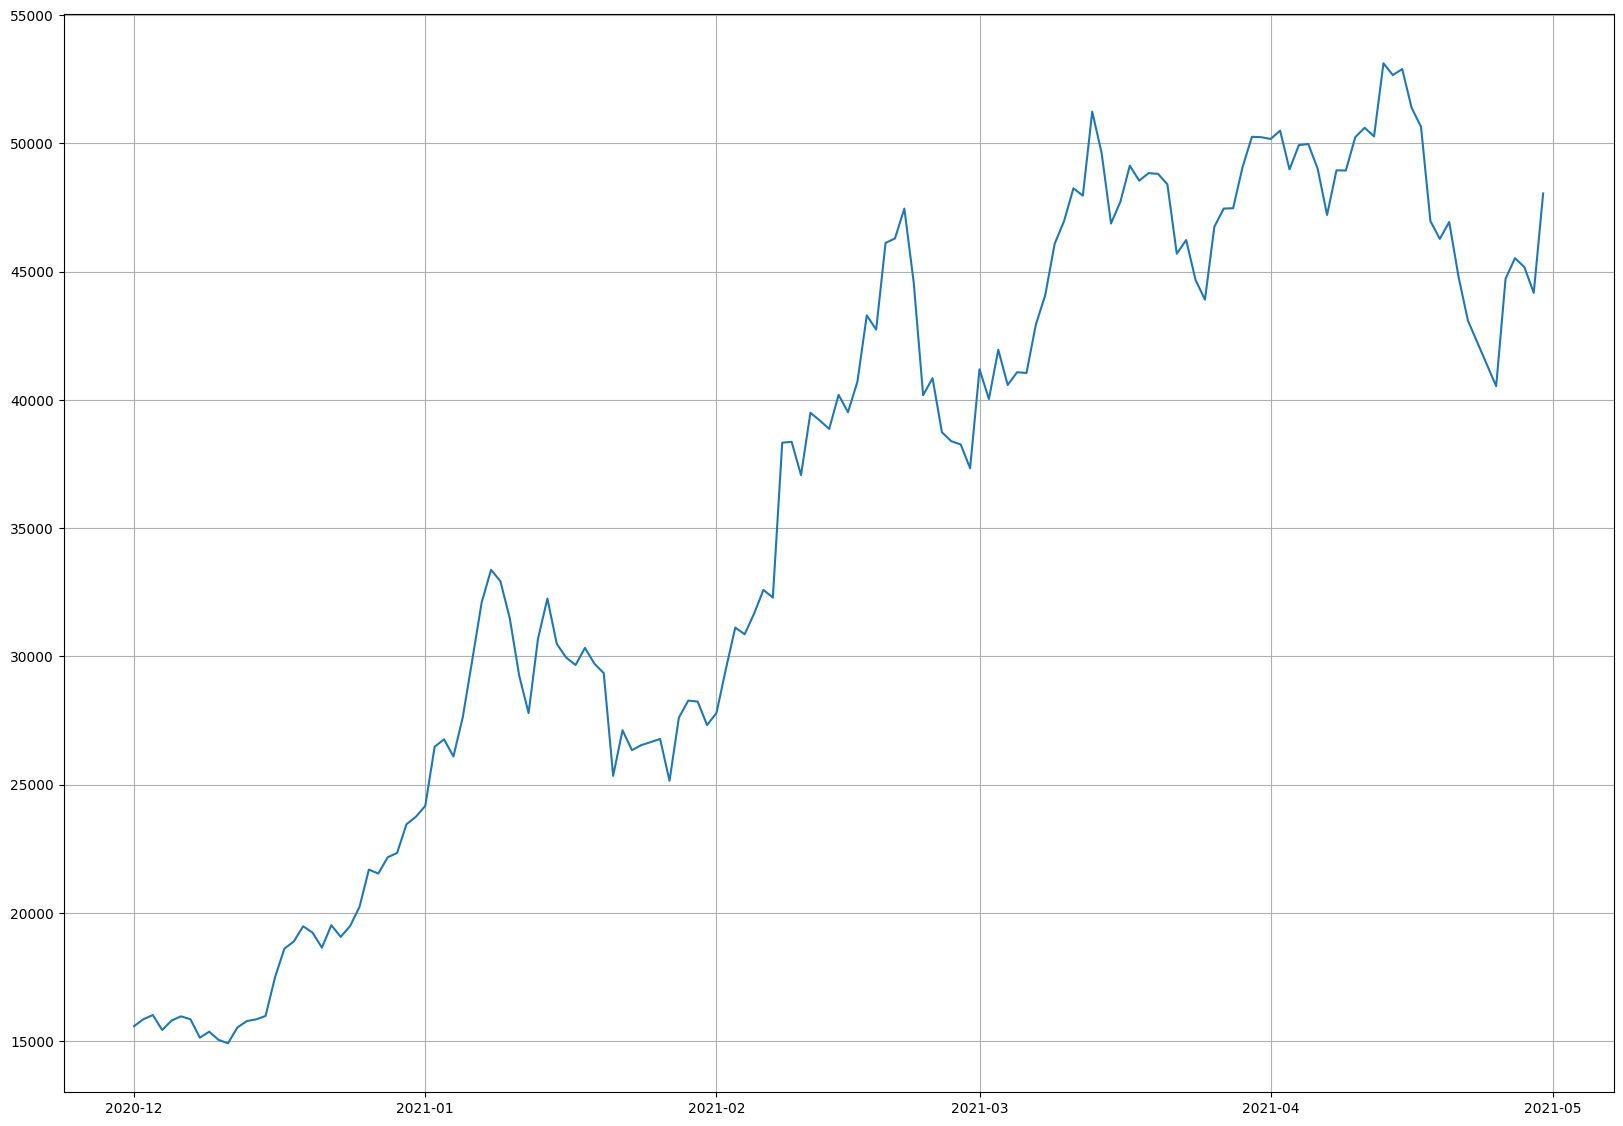

In [364]:
plt.figure(figsize=(20, 14))
plt.grid()
plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')

### Strategia

In [365]:
def lunghezza_media_salite_discese_consecutive(prices):
    if len(prices) < 1:
        raise ValueError("La lista dei prezzi deve contenere almeno 1 elemento per calcolare il numero medio di salite e discese consecutive.")

    up_lengths = []
    down_lengths = []

    current_trend = None
    count = 0

    for i in range(1, len(prices)):
        if prices.iloc[i] > prices.iloc[i-1]:  # Salita
            if current_trend == 'up':
                count += 1
            else:
                if current_trend == 'down':
                    down_lengths.append(count)
                current_trend = 'up'
                count = 1
        elif prices.iloc[i] < prices.iloc[i-1]:  # Discesa
            if current_trend == 'down':
                count += 1
            else:
                if current_trend == 'up':
                    up_lengths.append(count)
                current_trend = 'down'
                count = 1

    # Aggiungi l'ultima sequenza
    if current_trend == 'up':
        up_lengths.append(count)
    elif current_trend == 'down':
        down_lengths.append(count)

    return np.mean(up_lengths) if not np.isnan(np.mean(up_lengths)) else 0, np.mean(down_lengths) if not np.isnan(np.mean(down_lengths)) else 0

In [366]:
# Funzione per calcolare l'ultimo prezzo di riferimento discesa
def calcola_prezzo_riferimento_discesa(dati, soglia_discesa):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente < 1:  # Prezzo in discesa
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if variazione_cumulata - 1 >= soglia_discesa:
                # Se la variazione supera la soglia, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

# Funzione per calcolare l'ultimo prezzo di riferimento salita
def calcola_prezzo_riferimento_salita(dati, soglia_salita):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente > 1:  # Prezzo in salita
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if 1 - variazione_cumulata >= soglia_salita:
                # Se la variazione supera la soglia o il prezzo di riferimento è superiore al prezzo attuale, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

def calcola_percentuale(variazione, coefficienti):
    if isinstance(coefficienti, list):
        # Se coefficienti è una lista, esegue la somma ponderata delle variazioni
        return min(max(sum([c * variazione ** i for i, c in enumerate(coefficienti)]), 0), 1)
    
    elif isinstance(coefficienti, str):
        # Se coefficienti è una stringa, interpreta la stringa come una formula matematica
        # Sostituisci 'x' con il valore di variazione
        formula = coefficienti.replace('x', str(variazione))
        # Usa eval per calcolare il risultato
        try:
            risultato = eval(formula)
        except Exception as e:
            raise ValueError(f"Errore nell'interpretazione della formula: {e}")
        return min(max(risultato, 0), 1)
    
    else:
        raise TypeError("Il parametro 'coefficienti' deve essere una lista o una stringa.")

In [367]:
def trading_strategy(dati, liquidita_iniziale, token_iniziali, base_acquisto, potenza_acquisto, base_vendita, potenza_vendita, soglia_vendita, variabili_dinamiche, dinamismo_pre_finestra, finestra, metodo_percentuale_acquisto, metodo_percentuale_vendita, soglia_calcolo_variazioni_salita, soglia_calcolo_variazioni_discesa, coefficienti_acquisto, coefficienti_vendita, etichette):
    # Inizializzazione delle variabili
    liquidita = liquidita_iniziale
    token = token_iniziali
    discese_consecutive = 0
    salite_consecutive = 0
    transazioni = []

    # Per il calcolo della soglia di vendita
    prezzi_acquisto = []
    quantita_acquisto = []

    prezzi_vendita = [] # Lo uso solo per saperne la lunghezza in realtà, però mi salvo direttamente le vendite perchè magari in futuro vorrò usare anche questo, e poi per analogia con prezzi_acquisto (anzichè usare un contatore)

    mai_acquistato_o_venduto = True
    acquisti_consecutivi = 0
    vendite_consecutive = 0

    # Calcolo delle variazioni di prezzo
    dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

    for i, row in dati.iterrows():
        giorno = i
        prezzo = row['Price']
        variazione = row['Variazione']
        # print(f'Giorno {i}; prezzo {prezzo}, prezzi_acquisto {prezzi_acquisto}')

        # Aggiornamento dinamico delle potenze se richiesto
        if variabili_dinamiche and i >= finestra and not dinamismo_pre_finestra:
            prezzi_finestra = dati['Price'].iloc[i-finestra:i]
            durata_media_salita, durata_media_discesa = lunghezza_media_salite_discese_consecutive(prezzi_finestra)
            durata_media_salita_int, durata_media_discesa_int = round(durata_media_salita), round(durata_media_discesa)
            potenza_acquisto = 1 - durata_media_discesa_int
            potenza_vendita = 1 - durata_media_salita_int
        elif variabili_dinamiche and i < finestra and i >= 1 and dinamismo_pre_finestra:
            prezzi_finestra = dati['Price'].iloc[:i]
            durata_media_salita, durata_media_discesa = lunghezza_media_salite_discese_consecutive(prezzi_finestra)
            durata_media_salita_int, durata_media_discesa_int = round(durata_media_salita), round(durata_media_discesa)
            potenza_acquisto = 1 - durata_media_discesa_int
            potenza_vendita = 1 - durata_media_salita_int
        elif variabili_dinamiche and i >= finestra:
            prezzi_finestra = dati['Price'].iloc[i-finestra:i]
            durata_media_salita, durata_media_discesa = lunghezza_media_salite_discese_consecutive(prezzi_finestra)
            durata_media_salita_int, durata_media_discesa_int = round(durata_media_salita), round(durata_media_discesa)
            potenza_acquisto = 1 - durata_media_discesa_int
            potenza_vendita = 1 - durata_media_salita_int

        if variazione < 1:
            discese_consecutive += 1
            # acquisti_consecutivi = len(prezzi_acquisto)
            salite_consecutive = 0
            if metodo_percentuale_acquisto == 'Classico':
                percentuale_acquisto = base_acquisto ** (potenza_acquisto + acquisti_consecutivi)
            elif metodo_percentuale_acquisto == 'Funzione':
                # Cerca il prezzo di riferimento
                # prezzi_riferimento_discesa = []
                prezzo_riferimento = None
                variazione_cumulata = 1
                # gia_trovato = False
                cont = 0
                for j in range(i+1, 0, -1): # Controllare se è un errore il fatto che parto da len(dati) e non da i o i+1
                    variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
                    if pd.isna(variazione_giorno_precedente):
                        continue
                    if variazione_giorno_precedente < 1:
                        variazione_cumulata = 1
                        cont = 0
                        # gia_trovato = False
                    else:
                        variazione_cumulata *= variazione_giorno_precedente
                        if variazione_cumulata != variazione_giorno_precedente:
                            cont += 1
                        if variazione_cumulata - 1 >= soglia_calcolo_variazioni_discesa:
                            prezzo_riferimento = dati['Price'].iloc[j+cont-1]
                            # prezzi_riferimento_discesa.append((dati['Timestamp'].iloc[j+cont-1], prezzo_riferimento))
                            # variazione_cumulata = 1
                            # cont = 0
                            # gia_trovato = True
                            break
                if prezzo_riferimento is None:
                    prezzo_riferimento = dati['Price'].iloc[0]  # Usa il primo prezzo disponibile se nessun riferimento è trovato
                variazione_totale = abs(prezzo_riferimento - prezzo) / prezzo_riferimento
                # print(f'Variazione totale: {variazione_totale}')
                percentuale_acquisto = calcola_percentuale(variazione_totale, coefficienti_acquisto)
                prezzo_riferimento = None
                # print(f'Giorno {i}: percentuale acquisto risultante da mappatura è di {percentuale_acquisto}')
            else:
                raise ValueError("Metodo percentuale acquisto scelto non valido.")
            if percentuale_acquisto <= 1:
                quantita_eur = liquidita * percentuale_acquisto
                quantita_token = quantita_eur / prezzo
                liquidita -= quantita_eur
                token += quantita_token
                tipo = 'Acquisto' if quantita_eur > 0 else '-'
                if tipo == 'Acquisto':
                    if ultima_azione == 'Vendita' or mai_acquistato_o_venduto:
                        prezzi_acquisto = []
                        quantita_acquisto = []
                    prezzi_acquisto.append(prezzo)
                    quantita_acquisto.append(quantita_eur)
                    acquisti_consecutivi += 1
                    vendite_consecutive = 0
            else:
                quantita_eur = 0
                quantita_token = 0
                tipo = '-'
        elif variazione > 1:
            salite_consecutive += 1
            # vendite_consecutive = len(prezzi_vendita)
            discese_consecutive = 0

            # print(f'Giorno {i}; prezzi_acquisto: {prezzi_acquisto}; quantità_acquisto: {quantita_acquisto}')

            # Calcolo del prezzo medio pesato degli ultimi acquisti consecutivi
            if prezzi_acquisto and quantita_acquisto:
                prezzo_medio_pesato = np.average(prezzi_acquisto, weights=quantita_acquisto)
                if prezzo >= prezzo_medio_pesato * (1 + soglia_vendita):
                    if metodo_percentuale_vendita == 'Classico':
                        percentuale_vendita = base_vendita ** (potenza_vendita + vendite_consecutive)
                    elif metodo_percentuale_vendita == 'Funzione':
                        # Cerca il prezzo di riferimento
                        prezzo_riferimento = None
                        # prezzi_riferimento_salita = []
                        variazione_cumulata = 1
                        # gia_trovato = False
                        cont = 0
                        for j in range(i+1, 0, -1): # Controllare se è un errore il fatto che parto da len(dati) e non da i o i+1
                            variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
                            if pd.isna(variazione_giorno_precedente):
                                continue
                            if variazione_giorno_precedente > 1:
                                variazione_cumulata = 1
                                cont = 0
                                # gia_trovato = False
                            else:
                                variazione_cumulata *= variazione_giorno_precedente
                                if variazione_cumulata != variazione_giorno_precedente:
                                    cont += 1
                                if 1 - variazione_cumulata >= soglia_calcolo_variazioni_salita:
                                    prezzo_riferimento = dati['Price'].iloc[j+cont-1]
                                    # prezzi_riferimento_salita.append((dati['Timestamp'].iloc[j+cont-1], prezzo_riferimento))
                                    # variazione_cumulata = 1
                                    # cont = 0
                                    # gia_trovato = True
                                    break
                        if prezzo_riferimento is None:
                            prezzo_riferimento = dati['Price'].iloc[0]  # Usa il primo prezzo disponibile se nessun riferimento è trovato
                        variazione_totale = abs(prezzo_riferimento - prezzo) / prezzo_riferimento
                        percentuale_vendita = calcola_percentuale(variazione_totale, coefficienti_vendita)
                    else:
                        raise ValueError("Metodo percentuale vendita scelto non valido.")
                    if percentuale_vendita <= 1:
                        quantita_token_venduti = token * percentuale_vendita
                        quantita_eur_venduti = quantita_token_venduti * prezzo
                        liquidita += quantita_eur_venduti
                        token -= quantita_token_venduti
                        tipo = 'Vendita' if quantita_eur_venduti > 0 else '-'
                        if tipo == 'Vendita':
                            if ultima_azione == 'Acquisto' or mai_acquistato_o_venduto:
                                prezzi_vendita = []
                            prezzi_vendita.append(prezzo)
                            acquisti_consecutivi = 0
                            vendite_consecutive += 1
                    else:
                        quantita_eur_venduti = 0
                        quantita_token_venduti = 0
                        tipo = '-'
                else:
                    tipo = '-'
            else:
                tipo = '-'
        else:
            discese_consecutive = 0
            salite_consecutive = 0
            quantita_eur = 0
            quantita_token = 0
            tipo = '-'

        if tipo == 'Acquisto':
            euro_usati = quantita_eur
            token_usati = quantita_token
            perc_usata = percentuale_acquisto
            mai_acquistato_o_venduto = False
        elif tipo == 'Vendita':
            euro_usati = quantita_eur_venduti
            token_usati = quantita_token_venduti
            perc_usata = percentuale_vendita
            mai_acquistato_o_venduto = False
            # if len(prezzi_vendita) == 1:
            #     prezzi_acquisto = []
            #     quantita_acquisto = []
        else:
            euro_usati = 0
            token_usati = 0
            perc_usata = 0

        ultima_azione = tipo

        portafoglio_totale = liquidita + token * prezzo
        transazioni.append({
            'Data': row['Timestamp'],
            'Giorno': giorno,
            'Prezzo (€)': prezzo,
            'Liquidità (€)': liquidita,
            'Token': token,
            'Variazione prezzo': variazione,
            'Tipo': tipo,
            'Quantità (€)': euro_usati,
            'Quantità (token)': token_usati,
            '% Comprata/Venduta': perc_usata,
            'Portafoglio totale (€)': portafoglio_totale
        })

    # Creazione del DataFrame delle transazioni
    df_transazioni = pd.DataFrame(transazioni)

    # Filtrare acquisti e vendite
    acquisti = df_transazioni[df_transazioni['Tipo'] == 'Acquisto']
    vendite = df_transazioni[df_transazioni['Tipo'] == 'Vendita']

    # Calcolo delle dimensioni dei punti
    max_acquisto = acquisti['Quantità (€)'].max() if not acquisti.empty else 0
    max_vendita = vendite['Quantità (€)'].max() if not vendite.empty else 0

    def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita > 0 else min_size

    dimensioni_acquisti = [calcola_dimensione(x, max_acquisto) for x in acquisti['Quantità (€)']] if not acquisti.empty else []
    dimensioni_vendite = [calcola_dimensione(x, max_vendita) for x in vendite['Quantità (€)']] if not vendite.empty else []

    # Creazione del grafico
    plt.figure(figsize=(20, 14))
    plt.grid()
    plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')

    if not acquisti.empty:
        plt.scatter(acquisti['Data'], acquisti['Prezzo (€)'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
        if etichette:
            for i, row in acquisti.iterrows():
                plt.text(row['Data'], row['Prezzo (€)'], f"+{row['Quantità (€)']:.2f}", color='black', ha='center', va='bottom')

    if not vendite.empty:
        plt.scatter(vendite['Data'], vendite['Prezzo (€)'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
        if etichette:
            for i, row in vendite.iterrows():
                plt.text(row['Data'], row['Prezzo (€)'], f"-{row['Quantità (€)']:.2f}", color='black', ha='center', va='top')

    plt.xlabel('Data')
    plt.ylabel('Prezzo')
    plt.title('Prezzi con acquisti e vendite')
    plt.legend()
    plt.show()

    return df_transazioni

In [368]:
# def trading_strategy(dati, liquidita_iniziale, token_iniziali, base_acquisto, potenza_acquisto, base_vendita, potenza_vendita, soglia_vendita, variabili_dinamiche, dinamismo_pre_finestra, finestra, metodo_percentuale_acquisto, metodo_percentuale_vendita, soglia_calcolo_variazioni_salita, soglia_calcolo_variazioni_discesa, coefficienti_acquisto, coefficienti_vendita, etichette):
#     # Inizializzazione delle variabili
#     liquidita = liquidita_iniziale
#     token = token_iniziali
#     discese_consecutive = 0
#     salite_consecutive = 0
#     transazioni = []

#     # Per il calcolo della soglia di vendita
#     prezzi_acquisto = []
#     quantita_acquisto = []

#     prezzi_vendita = [] # Lo uso solo per saperne la lunghezza in realtà, però mi salvo direttamente le vendite perchè magari in futuro vorrò usare anche questo, e poi per analogia con prezzi_acquisto (anzichè usare un contatore)

#     mai_acquistato_o_venduto = True
#     acquisti_consecutivi = 0
#     vendite_consecutive = 0

#     # Calcolo delle variazioni di prezzo
#     dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

#     for i, row in dati.iterrows():
#         giorno = i
#         prezzo = row['Price']
#         variazione = row['Variazione']
#         # print(f'Giorno {i}; prezzo {prezzo}, prezzi_acquisto {prezzi_acquisto}')

#         # Aggiornamento dinamico delle potenze se richiesto
#         if variabili_dinamiche and i >= finestra and not dinamismo_pre_finestra:
#             prezzi_finestra = dati['Price'].iloc[i-finestra:i]
#             durata_media_salita, durata_media_discesa = lunghezza_media_salite_discese_consecutive(prezzi_finestra)
#             durata_media_salita_int, durata_media_discesa_int = round(durata_media_salita), round(durata_media_discesa)
#             potenza_acquisto = 1 - durata_media_discesa_int
#             potenza_vendita = 1 - durata_media_salita_int
#         elif variabili_dinamiche and i < finestra and i >= 1 and dinamismo_pre_finestra:
#             prezzi_finestra = dati['Price'].iloc[:i]
#             durata_media_salita, durata_media_discesa = lunghezza_media_salite_discese_consecutive(prezzi_finestra)
#             durata_media_salita_int, durata_media_discesa_int = round(durata_media_salita), round(durata_media_discesa)
#             potenza_acquisto = 1 - durata_media_discesa_int
#             potenza_vendita = 1 - durata_media_salita_int
#         elif variabili_dinamiche and i >= finestra:
#             prezzi_finestra = dati['Price'].iloc[i-finestra:i]
#             durata_media_salita, durata_media_discesa = lunghezza_media_salite_discese_consecutive(prezzi_finestra)
#             durata_media_salita_int, durata_media_discesa_int = round(durata_media_salita), round(durata_media_discesa)
#             potenza_acquisto = 1 - durata_media_discesa_int
#             potenza_vendita = 1 - durata_media_salita_int

#         if variazione < 1:
#             discese_consecutive += 1
#             # acquisti_consecutivi = len(prezzi_acquisto)
#             salite_consecutive = 0
#             if metodo_percentuale_acquisto == 'Classico':
#                 percentuale_acquisto = base_acquisto ** (potenza_acquisto + acquisti_consecutivi)
#             elif metodo_percentuale_acquisto == 'Funzione':

#                 # Cerca il prezzo di riferimento
#                 # prezzi_riferimento_discesa = []
#                 # prezzo_riferimento = None
#                 # variazione_cumulata = 1
#                 # gia_trovato = False
#                 # cont = 0
#                 # for j in range(len(dati), 0, -1):
#                 #     variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
#                 #     if pd.isna(variazione_giorno_precedente):
#                 #         continue
#                 #     if variazione_giorno_precedente < 1:
#                 #         variazione_cumulata = 1
#                 #         cont = 0
#                 #         gia_trovato = False
#                 #         continue
#                 #     else:
#                 #         variazione_cumulata *= variazione_giorno_precedente
#                 #         if variazione_cumulata != variazione_giorno_precedente:
#                 #             cont += 1
#                 #         if variazione_cumulata - 1 >= soglia_calcolo_variazioni_discesa and not gia_trovato:
#                 #             prezzo_riferimento = dati['Price'].iloc[j+cont-1]
#                             # prezzi_riferimento_discesa.append((dati['Timestamp'].iloc[j+cont-1], prezzo_riferimento))
#                             # variazione_cumulata = 1
#                             # cont = 0
#                             # gia_trovato = True
#                 prezzo_riferimento = calcola_prezzo_riferimento_discesa(dati.iloc[:i+1], soglia_calcolo_variazioni_discesa)[1]
#                 # if prezzo_riferimento is None:
#                 #     prezzo_riferimento = dati['Price'].iloc[0]  # Usa il primo prezzo disponibile se nessun riferimento è trovato
#                 variazione_totale = abs(prezzo_riferimento - prezzo) / prezzo_riferimento
#                 # print(f'Variazione totale: {variazione_totale}')
#                 percentuale_acquisto = calcola_percentuale(variazione_totale, coefficienti_acquisto)
#                 prezzo_riferimento = None
#                 # print(f'Giorno {i}: percentuale acquisto risultante da mappatura è di {percentuale_acquisto}')
#             else:
#                 raise ValueError("Metodo percentuale acquisto scelto non valido.")
#             if percentuale_acquisto <= 1:
#                 quantita_eur = liquidita * percentuale_acquisto
#                 quantita_token = quantita_eur / prezzo
#                 liquidita -= quantita_eur
#                 token += quantita_token
#                 tipo = 'Acquisto' if quantita_eur > 0 else '-'
#                 if tipo == 'Acquisto':
#                     if ultima_azione == 'Vendita' or mai_acquistato_o_venduto:
#                         prezzi_acquisto = []
#                         quantita_acquisto = []
#                     prezzi_acquisto.append(prezzo)
#                     quantita_acquisto.append(quantita_eur)
#                     acquisti_consecutivi += 1
#                     vendite_consecutive = 0
#             else:
#                 quantita_eur = 0
#                 quantita_token = 0
#                 tipo = '-'
#         elif variazione > 1:
#             salite_consecutive += 1
#             # vendite_consecutive = len(prezzi_vendita)
#             discese_consecutive = 0

#             # print(f'Giorno {i}; prezzi_acquisto: {prezzi_acquisto}; quantità_acquisto: {quantita_acquisto}')

#             # Calcolo del prezzo medio pesato degli ultimi acquisti consecutivi
#             if prezzi_acquisto and quantita_acquisto:
#                 prezzo_medio_pesato = np.average(prezzi_acquisto, weights=quantita_acquisto)
#                 if prezzo >= prezzo_medio_pesato * (1 + soglia_vendita):
#                     if metodo_percentuale_vendita == 'Classico':
#                         percentuale_vendita = base_vendita ** (potenza_vendita + vendite_consecutive)
#                     elif metodo_percentuale_vendita == 'Funzione':

#                         # Cerca il prezzo di riferimento
#                         # prezzo_riferimento = None
#                         # # prezzi_riferimento_salita = []
#                         # variazione_cumulata = 1
#                         # gia_trovato = False
#                         # cont = 0
#                         # for j in range(len(dati), 0, -1):
#                         #     variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
#                         #     if pd.isna(variazione_giorno_precedente):
#                         #         continue
#                         #     if variazione_giorno_precedente > 1:
#                         #         variazione_cumulata = 1
#                         #         cont = 0
#                         #         gia_trovato = False
#                         #         continue
#                         #     else:
#                         #         variazione_cumulata *= variazione_giorno_precedente
#                         #         if variazione_cumulata != variazione_giorno_precedente:
#                         #             cont += 1
#                         #         if 1 - variazione_cumulata >= soglia_calcolo_variazioni_salita and not gia_trovato:
#                         #             prezzo_riferimento = dati['Price'].iloc[j+cont-1]
#                         #             # prezzi_riferimento_salita.append((dati['Timestamp'].iloc[j+cont-1], prezzo_riferimento))
#                         #             variazione_cumulata = 1
#                         #             cont = 0
#                         #             gia_trovato = True
#                         prezzo_riferimento = calcola_prezzo_riferimento_salita(dati.iloc[:i+1], soglia_calcolo_variazioni_salita)[1]

#                         # if prezzo_riferimento is None:
#                         #     prezzo_riferimento = dati['Price'].iloc[0]  # Usa il primo prezzo disponibile se nessun riferimento è trovato
#                         variazione_totale = abs(prezzo_riferimento - prezzo) / prezzo_riferimento
#                         percentuale_vendita = calcola_percentuale(variazione_totale, coefficienti_vendita)
#                     else:
#                         raise ValueError("Metodo percentuale vendita scelto non valido.")
#                     if percentuale_vendita <= 1:
#                         quantita_token_venduti = token * percentuale_vendita
#                         quantita_eur_venduti = quantita_token_venduti * prezzo
#                         liquidita += quantita_eur_venduti
#                         token -= quantita_token_venduti
#                         tipo = 'Vendita' if quantita_eur_venduti > 0 else '-'
#                         if tipo == 'Vendita':
#                             if ultima_azione == 'Acquisto' or mai_acquistato_o_venduto:
#                                 prezzi_vendita = []
#                             prezzi_vendita.append(prezzo)
#                             acquisti_consecutivi = 0
#                             vendite_consecutive += 1
#                     else:
#                         quantita_eur_venduti = 0
#                         quantita_token_venduti = 0
#                         tipo = '-'
#                 else:
#                     tipo = '-'
#             else:
#                 tipo = '-'
#         else:
#             discese_consecutive = 0
#             salite_consecutive = 0
#             quantita_eur = 0
#             quantita_token = 0
#             tipo = '-'

#         if tipo == 'Acquisto':
#             euro_usati = quantita_eur
#             token_usati = quantita_token
#             perc_usata = percentuale_acquisto
#             mai_acquistato_o_venduto = False
#         elif tipo == 'Vendita':
#             euro_usati = quantita_eur_venduti
#             token_usati = quantita_token_venduti
#             perc_usata = percentuale_vendita
#             mai_acquistato_o_venduto = False
#             # if len(prezzi_vendita) == 1:
#             #     prezzi_acquisto = []
#             #     quantita_acquisto = []
#         else:
#             euro_usati = 0
#             token_usati = 0
#             perc_usata = 0

#         ultima_azione = tipo

#         portafoglio_totale = liquidita + token * prezzo
#         transazioni.append({
#             'Data': row['Timestamp'],
#             'Giorno': giorno,
#             'Prezzo (€)': prezzo,
#             'Liquidità (€)': liquidita,
#             'Token': token,
#             'Variazione prezzo': variazione,
#             'Tipo': tipo,
#             'Quantità (€)': euro_usati,
#             'Quantità (token)': token_usati,
#             '% Comprata/Venduta': perc_usata,
#             'Portafoglio totale (€)': portafoglio_totale
#         })

#     # Creazione del DataFrame delle transazioni
#     df_transazioni = pd.DataFrame(transazioni)

#     # Filtrare acquisti e vendite
#     acquisti = df_transazioni[df_transazioni['Tipo'] == 'Acquisto']
#     vendite = df_transazioni[df_transazioni['Tipo'] == 'Vendita']

#     # Calcolo delle dimensioni dei punti
#     max_acquisto = acquisti['Quantità (€)'].max() if not acquisti.empty else 0
#     max_vendita = vendite['Quantità (€)'].max() if not vendite.empty else 0

#     def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
#         return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita > 0 else min_size

#     dimensioni_acquisti = [calcola_dimensione(x, max_acquisto) for x in acquisti['Quantità (€)']] if not acquisti.empty else []
#     dimensioni_vendite = [calcola_dimensione(x, max_vendita) for x in vendite['Quantità (€)']] if not vendite.empty else []

#     # Creazione del grafico
#     plt.figure(figsize=(20, 14))
#     plt.grid()
#     plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')

#     if not acquisti.empty:
#         plt.scatter(acquisti['Data'], acquisti['Prezzo (€)'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
#         if etichette:
#             for i, row in acquisti.iterrows():
#                 plt.text(row['Data'], row['Prezzo (€)'], f"+{row['Quantità (€)']:.2f}", color='black', ha='center', va='bottom')

#     if not vendite.empty:
#         plt.scatter(vendite['Data'], vendite['Prezzo (€)'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
#         if etichette:
#             for i, row in vendite.iterrows():
#                 plt.text(row['Data'], row['Prezzo (€)'], f"-{row['Quantità (€)']:.2f}", color='black', ha='center', va='top')

#     plt.xlabel('Data')
#     plt.ylabel('Prezzo')
#     plt.title('Prezzi con acquisti e vendite')
#     plt.legend()
#     plt.show()

#     return df_transazioni

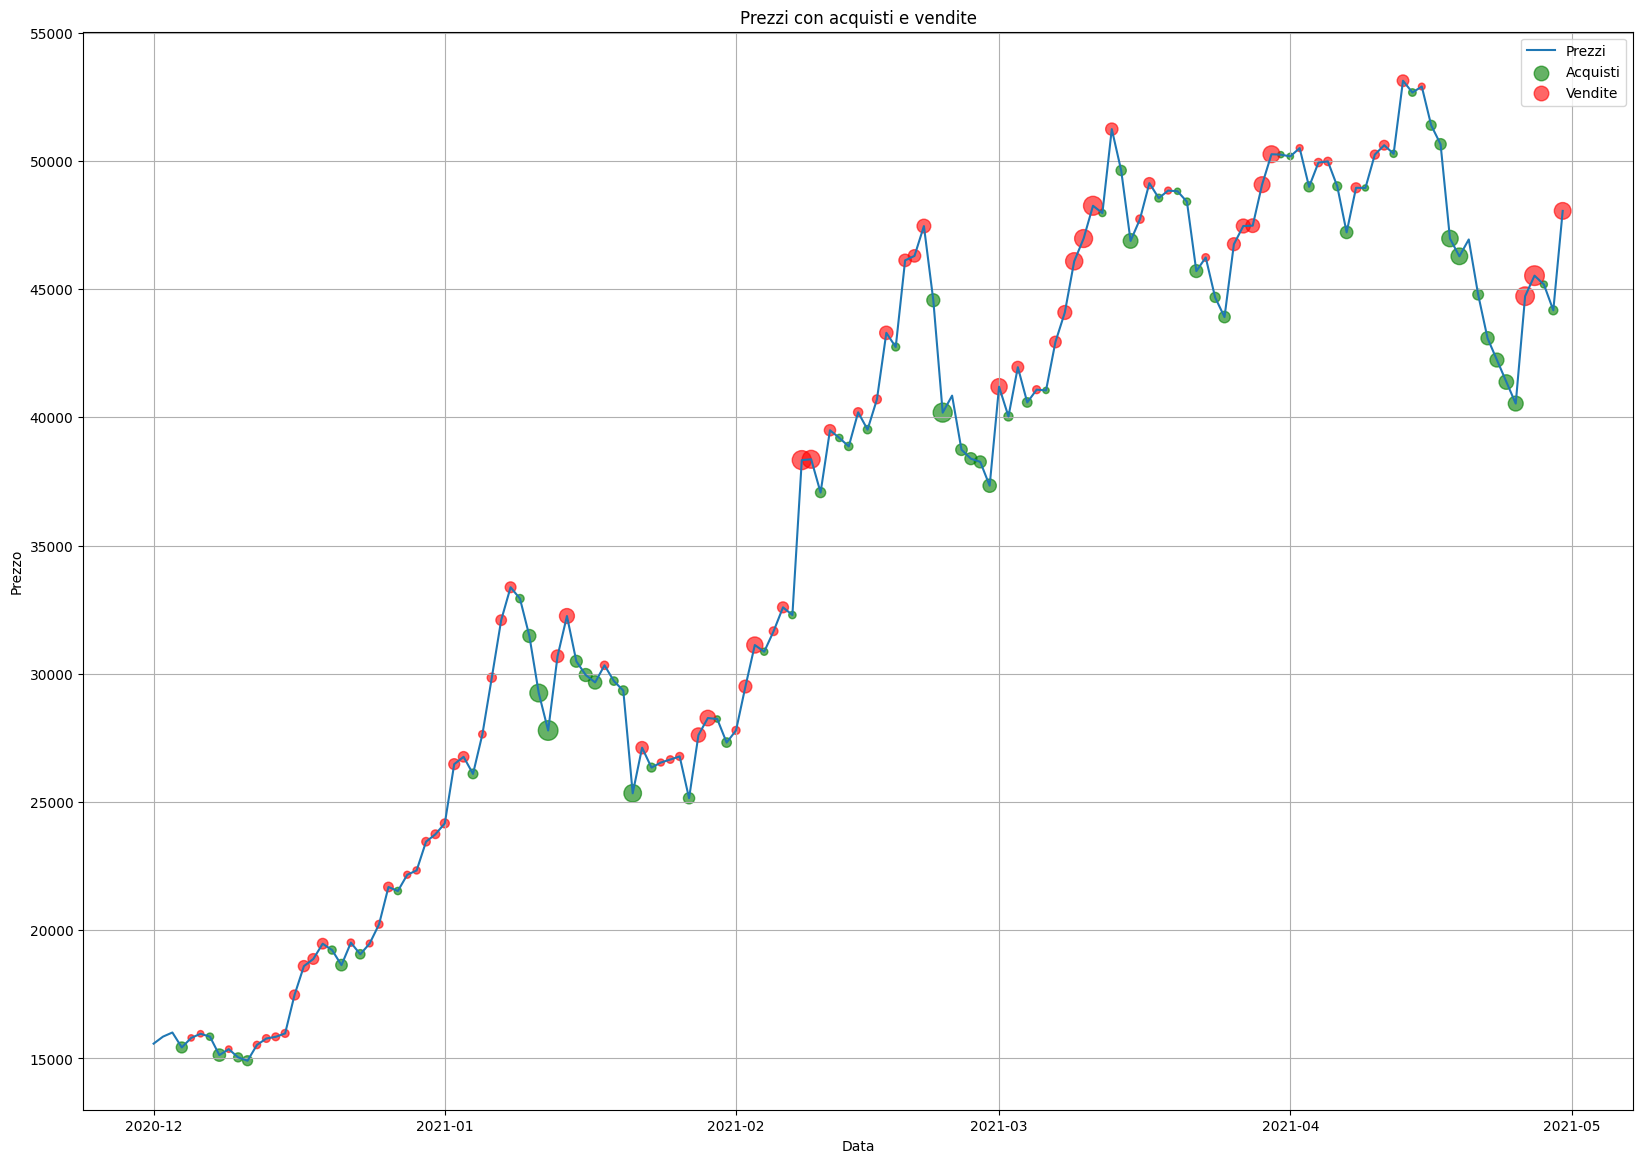

,Data,Giorno,Prezzo (€),Liquidità (€),Token,Variazione prezzo,Tipo,Quantità (€),Quantità (token),% Comprata/Venduta,Portafoglio totale (€)
0,2020-12-01,0,15576.629883,1000.000000,0.000000,NaN,-,0.000000,0.000000,0.000000,1000.000000
1,2020-12-02,1,15850.040039,1000.000000,0.000000,1.017553,-,0.000000,0.000000,0.000000,1000.000000
2,2020-12-03,2,16010.777344,1000.000000,0.000000,1.010141,-,0.000000,0.000000,0.000000,1000.000000
3,2020-12-04,3,15428.222656,974.459008,0.001655,0.963615,Acquisto,25.540992,0.001655,0.025541,1000.000000
4,2020-12-05,4,15799.846680,974.899379,0.001628,1.024087,Vendita,0.440371,0.000028,0.016836,1000.615213
...,...,...,...,...,...,...,...,...,...,...,...
146,2021-04-26,146,44721.855469,575.498674,0.016431,1.103310,Vendita,58.922854,0.001318,0.074235,1310.307202
147,2021-04-27,147,45522.515625,642.100602,0.014968,1.017903,Vendita,66.601929,0.001463,0.089044,1323.462557
148,2021-04-28,148,45178.683594,638.730167,0.015042,0.992447,Acquisto,3.370435,0.000075,0.005249,1318.316223
149,2021-04-29,149,44170.968750,625.449370,0.015343,0.977695,Acquisto,13.280797,0.000301,0.020793,1303.157992


In [369]:
# Esempio di utilizzo
# np.random.seed(16)
# dati = pd.DataFrame({
#     'Timestamp': pd.date_range(start='2023-01-01', periods=30, freq='D'),
#     'Price': np.random.uniform(100, 200, 30)
# })

# Parametri fissi
liquidita_iniziale = 1000
token_iniziali = 0

# Parametri variabili
base_acquisto = 2
potenza_acquisto = -5
base_vendita = 2
potenza_vendita = -7
soglia_vendita = 0
variabili_dinamiche = False
dinamismo_pre_finestra = False # Se è True, aggiorna dinamicamente le variabili anche prima che ci siano almeno "finestra" giorni nel passato
finestra = 30
metodo_percentuale_acquisto = 'Funzione' # Scegliere tra 'Classico' e 'Funzione; se è 'Classico', usa le potenze per come avevo pensato inizialmente alla strategia; se è 'Funzione' la percentuale acquisto viene calcolata, se coefficienti_acquisto è una lista, come una funzione (polinomio che ha come coefficienti coefficienti_acquisto) della variazione percentuale avvenuta rispetto all'inizio della discesa (dove, per capire dove è iniziata la discesa, vengono trascurate le salite troppo piccole), mentre se coefficienti_acquisto è una stringa viene usata una funzione generica da passare come stringa a coefficienti_acquisto
metodo_percentuale_vendita = 'Funzione' # Analogo al metodo_percentuale_acquisto, ma con le vendite
soglia_calcolo_variazioni_salita = 0 # Per sapere come calcolare la variazione di prezzo di una salita, in totale, non considera le piccole discese, dove "piccole" significa di una percentuale inferiore a soglia_calcolo_variazioni_salita
soglia_calcolo_variazioni_discesa = 0 # Analogo di soglia_calcolo_variazioni_salita ma durante una salita e trascurando le piccole salite sotto una percentuale soglia_calcolo_variazioni_discesa
coefficienti_acquisto = '2**x - 1' # [0, 1]
coefficienti_vendita = '2**x - 1' # [0, 1]

etichette = False

df_transazioni = trading_strategy(dati, liquidita_iniziale, token_iniziali, base_acquisto, potenza_acquisto, base_vendita, potenza_vendita, soglia_vendita, variabili_dinamiche, dinamismo_pre_finestra, finestra, metodo_percentuale_acquisto, metodo_percentuale_vendita, soglia_calcolo_variazioni_salita, soglia_calcolo_variazioni_discesa, coefficienti_acquisto, coefficienti_vendita, etichette)
df_transazioni

In [370]:
lunghezza_media_salite_discese_consecutive(dati['Price'])

(2.1025641025641026, 1.7894736842105263)

In [371]:
df_transazioni[:40]

,Data,Giorno,Prezzo (€),Liquidità (€),Token,Variazione prezzo,Tipo,Quantità (€),Quantità (token),% Comprata/Venduta,Portafoglio totale (€)
0,2020-12-01,0,15576.629883,1000.000000,0.000000,NaN,-,0.000000,0.000000,0.000000,1000.000000
1,2020-12-02,1,15850.040039,1000.000000,0.000000,1.017553,-,0.000000,0.000000,0.000000,1000.000000
2,2020-12-03,2,16010.777344,1000.000000,0.000000,1.010141,-,0.000000,0.000000,0.000000,1000.000000
3,2020-12-04,3,15428.222656,974.459008,0.001655,0.963615,Acquisto,25.540992,0.001655,0.025541,1000.000000
4,2020-12-05,4,15799.846680,974.899379,0.001628,1.024087,Vendita,0.440371,0.000028,0.016836,1000.615213
5,2020-12-06,5,15961.175781,975.528915,0.001588,1.010211,Vendita,0.629537,0.000039,0.024233,1000.877792
6,2020-12-07,6,15847.105469,970.684409,0.001894,0.992853,Acquisto,4.844506,0.000306,0.004966,1000.696631
7,2020-12-08,7,15129.400391,934.980809,0.004254,0.954711,Acquisto,35.703600,0.002360,0.036782,999.337397
8,2020-12-09,8,15361.175781,935.678358,0.004208,1.015320,Vendita,0.697549,0.000045,0.010675,1000.323310
9,2020-12-10,9,15040.947266,922.059864,0.005114,0.979153,Acquisto,13.618494,0.000905,0.014555,998.975681


In [372]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [373]:
rendimento_ottenuto = df_transazioni['Portafoglio totale (€)'].iloc[-1] / df_transazioni['Portafoglio totale (€)'].iloc[0]
rendimento_ideale = calcola_rendimento_portafoglio_ideale(df_transazioni['Liquidità (€)'].iloc[0], df_transazioni['Token'].iloc[0], df_transazioni['Prezzo (€)'], 0, 0, 0, 0)[0]
punteggio_rendimento = rendimento_ottenuto / rendimento_ideale
print('Rendimento ottenuto:', rendimento_ottenuto)
print('Rendimento ideale:', rendimento_ideale)
print('Punteggio rendimento:', str(round(punteggio_rendimento*100, 2)) + '%')

Rendimento ottenuto: 1.3626281432049043
Rendimento ideale: 19.612862981461895
Punteggio rendimento: 6.95%
